In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import time

# Q1 (a)
## European option pricing

In [48]:

def TrinomialTree(s0,sigma,lmda,r,N,payoff,T,K):
    #Create an empty array to store the stock price at each node
    #note since u=1/d this is a recombining tree
    delta_t=T/N
    
    #set up parameters
    u=np.exp(lmda*sigma*np.sqrt(delta_t))
    d=1/u
    qu=1/(2*lmda**2)+((r-sigma**2/2)*np.sqrt(delta_t))/(2*lmda*sigma)
    qm=1-1/lmda**2
    qd=1/(2*lmda**2)-((r-sigma**2/2)*np.sqrt(delta_t))/(2*lmda*sigma)
    
    
    S=np.zeros((2*N+1,N+1))
    V=np.zeros((2*N+1,N+1))

    #set up S[k,n]=s0*u^(n-k) = s0*u^n*d^k for 0<=k<=2n
    for t in range(N+1):
        S[0:2*t+1,t]=(s0*u**t)*(d**(np.arange(0,2*t+1)))

    #apply payoff
    V[:,N]=payoff(S[:,N],K)
    
    #Loop backwards in time
    for t in reversed(range(N)):
        V[0:2*t+1,t]=(qu*V[0:2*t+1,t+1]+qm*V[1:2*t+2,t+1]+qd*V[2:2*t+3,t+1])*np.exp(-r*delta_t)
        
    return V, S #return tree of both stock and asset price


In [49]:
N=200
s0=100
K=100
sigma=0.2
T=1
r=0.01
g=lambda x,k:np.maximum(x-k,0)
lmda_vec=[1,1.25,1.5,1.75]

option_price_df=pd.DataFrame(np.zeros((N,4)))
option_price=np.zeros(N)
for i,lmda in enumerate(lmda_vec):
    for n in range(1,N+1):
        v=TrinomialTree(s0,sigma,lmda,r,n,g,T,K)[0]
        option_price[n-1]=v[0,0]
    option_price_df[i]=option_price
    
option_price_df.columns=["Lambda=%.2f"%f for f in lmda_vec]
option_price_df.index=np.arange(1,201,1)

In [50]:
option_price_df

,Lambda=1.00,Lambda=1.25,Lambda=1.50,Lambda=1.75
1,10.411989,8.435979,7.119985,6.181130
2,7.529081,8.143974,7.787382,7.222898
3,9.101786,8.277451,8.009994,7.651916
4,7.956374,8.301345,8.118027,7.867494
5,8.832133,8.328068,8.181904,7.991876
...,...,...,...,...
196,8.423189,8.430423,8.426960,8.422862
197,8.443264,8.430437,8.426993,8.422916
198,8.423291,8.430452,8.427025,8.422968
199,8.443164,8.430466,8.427056,8.423020


In [51]:
#Exact Black Scholes price

def CallBlackScholes(s,r,sigma,t,k):
    d1=(np.log(s/k)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
    d2=d1-np.sqrt(t)*sigma
    
    return s*stats.norm.cdf(d1)-k*np.exp(-r*t)*stats.norm.cdf(d2)

Text(0.5, 1.0, 'Plot of European Call Option Prices using trinomial model')

<Figure size 432x288 with 0 Axes>

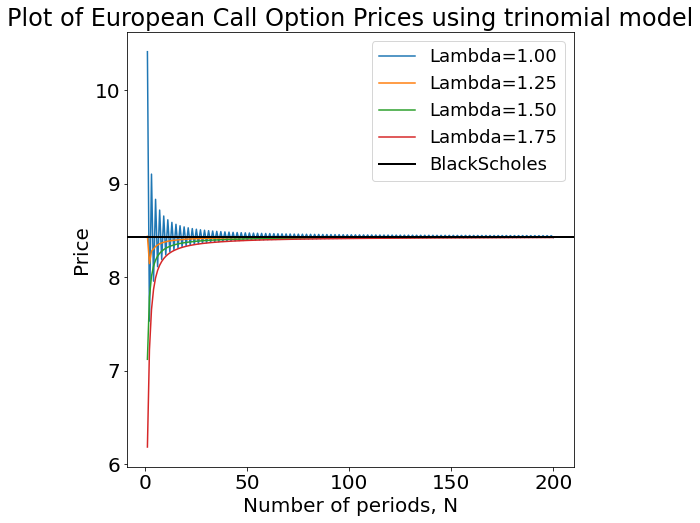

In [52]:
plt.figure()
plt.rcParams.update({'font.size':20})

ax=option_price_df.plot(figsize=(8,8),ylabel="Price",xlabel="Number of periods, N")

ax.axhline(CallBlackScholes(s0,r,sigma,T,K),label="BlackScholes",color="black",lw=2)
ax.legend(fontsize=18)
ax.set_title("Plot of European Call Option Prices using trinomial model")

From the plot it is clear that for any choice of $\lambda$ when the number of periods N is small (less than 10), the estimated call price will differ significantly from the theoretical Black Scholes price. Similarly for each choice of $\lambda$ as N increases we see that the price generated by the trinomial tree converges to that of the Black Scholes framework. This result is expected as the black scholes model works in continuous time, where as the trinomial tree discretises the call option price at fixed time points. So naturally as we make our lattice finer and finer we have a better approximation of a continuous time process.

Choosing $\lambda=1$, we observe that the trinomial model price oscillates above and below the Black Scholes price before converging. In the case of $\lambda=1$ it should be noted that the trinomial model reduces to the binomial model, as the probability of the "middle" movement becomes 0.

For the other choice of $\lambda$ it appears as if they initially underestimate the price and then also converge quickly, however they do not oscillate.

This difference may arise from the fact that when the model reduces to the binomial case the process is only allowed to move up or down by a proportional amount. By allowing the asset price to not move at all it provides a better approximation for extremely small movements in the continuous time case. This is particualrly the case when we only use a small number of periods as we see here. Alongside this, since the Black Scholes model essentially assumes a positive drift for the asset price when $r=0.01$ then we would expect the asset price, and so to the call price, to show only a slight upward trend over time, as such negligible movements will be common. 

In the trinomial model we have 2 cases in which the asset moves down or not at all. In these cases we could essentially be underestimating the price. This might be the reason all the estimates for $\lambda>1$ converge from below. In the binomial case there is only 1 case of this potential underestimation, when the asset moves down, this is likely the reason we observe oscillations for $\lambda=1$. Again this is only really significant when we have to approximate a large time frame with a small number of periods, and the asset can only move a small number of times.

$\lambda=1.25$ and $\lambda=1.5$ seem to converge the fastets in this case.

Varying $S_0$...

In [60]:
from ipywidgets import interact
@interact(s0=(50,180,10))
def call_plots(s0=110):
    N=150
    K=100
    sigma=0.2
    T=1
    r=0.01
    g=lambda x,k:np.maximum(x-k,0)
    lmda_vec=[1,1.25,1.5,1.75]

    option_price_df=pd.DataFrame(np.zeros((N,4)))
    option_price=np.zeros(N)
    for i,lmda in enumerate(lmda_vec):
        for n in range(1,N+1):
            v=TrinomialTree(s0,sigma,lmda,r,n,g,T,K)[0]
            option_price[n-1]=v[0,0]
        option_price_df[i]=option_price

    option_price_df.columns=["Lambda=%.2f"%f for f in lmda_vec]
    plt.figure()
    plt.rcParams.update({'font.size':18})
    ax=option_price_df.plot(figsize=(8,8),ylabel="Price",xlabel="Number of periods, N")

    ax.axhline(CallBlackScholes(s0,r,sigma,T,K),label="BlackScholes",color="black",lw=2)
    ax.legend(fontsize=18)
    ax.set_title("Plot of European Call Option Prices using trinomial model")
    return ax

interactive(children=(IntSlider(value=110, description='s0', max=180, min=50, step=10), Output()), _dom_classe…

Note the above graph can be somewhat slow to update when using the slider.

The convergence of each model differs significantly from the case when $S_0=K$. This can be broken into 2 cases, when the asset price is greater than the strike, and when the asset price is below the strike.

Case $S_0>K$:
Here we observe that the initial difference between the black scholes and trinomial prices shrinks as the asset price becomes increasingly large. This is because the asset is more likely to finish in the money, and so the value of the call option approcahes the value of the asset, in particular the initial price of the call approaches the constant $S_0$. Although the convergence may look more oscillatory, when we look at the scale of the axis we see that we are already within one to two decimal place of accuracy.

Case $S_0<K$:
Again we observer that the initial difference between the trinomial and black scholes model shrinks as the asset prices decreases. This is because the asset is more likely to finish below the strike, and the value of the call tends to 0. We can see this just by looking at the scale of the axis as we decrease $S_0$.

When $S_0$ is closer to $K$ it is harder to determine whether or not the option will expire in the money, so when the asset moves up or down this can have a more significant influence on the price of the call.

Fixing N=500...

In [8]:

N=500
K=100
s0=np.arange(70,140,10)
M=len(s0)
lmda_vec=[1,1.25,1.5,1.75]
sigma=0.2
T=1
r=0.01
g=lambda x,k:np.maximum(x-k,0)

option_price_df_s0=pd.DataFrame(np.zeros((M,4))) #table of trinomial values
option_price=np.zeros(M)

for i,lmda in enumerate(lmda_vec):
    #update for lambda
    for m in range(0,M):
        #update for new value of S0 at each step
        v=TrinomialTree(s0[m],sigma,lmda,r,N,g,T,K)[0]
        option_price[m]=v[0,0]-CallBlackScholes(s0[m],r,sigma,T,K)
    option_price_df_s0[i]=option_price
    
option_price_df_s0.columns=["Lambda=%.2f"%f for f in lmda_vec]
option_price_df_s0.index=[i for i in s0]
option_price_df_s0.index.name="S0"

In [9]:
option_price_df_s0

,Lambda=1.00,Lambda=1.25,Lambda=1.50,Lambda=1.75
S0,,,,
70,-0.001211,-0.000595,0.000036,0.000038
80,0.001067,-0.000974,0.000506,0.000257
90,-0.001083,0.001322,-0.000349,0.000592
100,-0.003972,-0.001136,-0.002492,-0.004095
110,0.002474,0.001615,-0.000864,-0.001966
120,-0.000100,0.000526,0.000999,0.001022
130,0.000462,0.000182,0.000497,0.000189


In [10]:
np.sqrt((option_price_df_s0**2)).mean(axis=0)

Lambda=1.00    0.001481
Lambda=1.25    0.000907
Lambda=1.50    0.000821
Lambda=1.75    0.001166
dtype: float64

In most cases, except when the initial asset price equals the strike, we already have 2 decimal places of accuracy, which is typically all we require when working in pounds. Generally the values of lambda that provide the smallest error are either 1.25 or 1.50. This is also generally consistent with what we see in the plots. In general by using N=500 steps we are approximating the black scholes price of the call option quite well, since we have $T=1$ year, we are essentially allowing the asset to move twice every trading day. This seems to be a sufficiently fine lattice for approximating continuous time.

On average $\lambda=1.50$ offers the lowest error when compared with Black Scholes prices

Choose $\lambda=1.5$

# Q1 (b)
## American Option

In [11]:

def AmericanTrinomialTree(s0,sigma,lmda,r,N,payoff,T,K):
    #Create an empty array to store the stock price at each node
    #note since u=1/d this is a recombining tree
    delta_t=T/N
    
    #set up parameters
    u=np.exp(lmda*sigma*np.sqrt(delta_t))
    d=1/u
    qu=1/(2*lmda**2)+((r-sigma**2/2)*np.sqrt(delta_t))/(2*lmda*sigma)
    qm=1-1/lmda**2
    qd=1/(2*lmda**2)-((r-sigma**2/2)*np.sqrt(delta_t))/(2*lmda*sigma)
    
    S=np.zeros((2*N+1,N+1))
    V=np.zeros((2*N+1,N+1))

    #set up S[k,n]=s0*u^(n-k) = s0*u^n*d^k for 0<=k<=2n
    for t in range(N+1):
        S[0:2*t+1,t]=(s0*u**t)*(d**(np.arange(0,2*t+1)))

    #apply payoff
    V[:,N]=payoff(S[:,N],K)

    #Loop backwards in time
    for t in reversed(range(N)):
        V[0:2*t+1,t]=np.maximum(payoff(S[0:2*t+1,t],K),(qu*V[0:2*t+1,t+1]+qm*V[1:2*t+2,t+1]+qd*V[2:2*t+3,t+1])*np.exp(-r*delta_t))

    return V, S #return tree of both stock and asset price


In [12]:
N=500
s0=np.arange(70,131,1)
K=100
lmda=1.5
sigma=0.2
T=1
r=0.01
M=len(s0)
g=lambda x,k:np.maximum(x-k,0)

american_call=np.zeros((M,2))

for i,s in enumerate(s0):
    V=AmericanTrinomialTree(s,sigma,lmda,r,N,g,T,K)[0]
    american_call[i,0]=V[0,0] #time-zero value of option
    american_call[i,1]=g(s,K) #intrinsic value of option
    
american_df=pd.DataFrame(american_call,columns=["Call_Value","Intrinsic_Value"])
american_df.index=s0

Text(0.5, 1.0, 'American Call Option Price vs Intrinsic Value')

<Figure size 432x288 with 0 Axes>

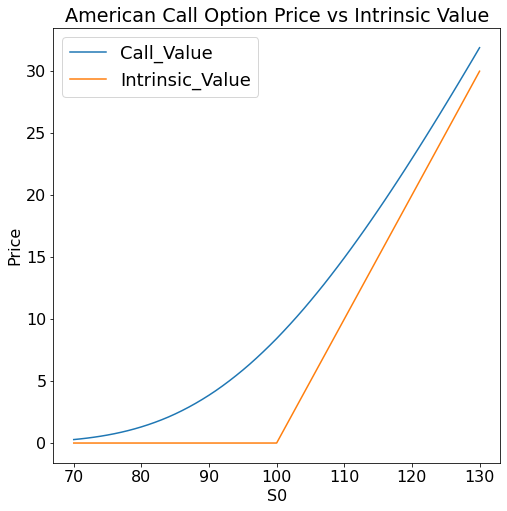

In [63]:
plt.figure()
plt.rcParams.update({'font.size':16})
american_df.plot(xlabel="S0",ylabel="Price",figsize=(8,8))
plt.legend(fontsize=18)
plt.title("American Call Option Price vs Intrinsic Value")

Based on this graph, since the continuation value, the call value, is always above the intrinsic value then it is never optimal to exercise early at time 0. This is what we would expect to observe as it is tpyically never optimal to exercise an american call option early.

In [29]:
put_payoff=lambda x,k:np.maximum(k-x,0)
N=500
s0=np.arange(70,131,1)
K=100
lmda=1.5
sigma=0.2
T=1
r=0.01
M=len(s0)

american_put=np.zeros((M,2))

for i,s in enumerate(s0):
    V=AmericanTrinomialTree(s,sigma,lmda,r,N,put_payoff,T,K)[0]
    american_put[i,0]=V[0,0] #time-zero value of option
    american_put[i,1]=put_payoff(s,K) #intrinsic value of option
    
american_put_df=pd.DataFrame(american_put,columns=["Put_Value","Intrinsic_Value"])
american_put_df.index=s0

Text(0.5, 1.0, 'American Put Option Price vs Intrinsic Value')

<Figure size 432x288 with 0 Axes>

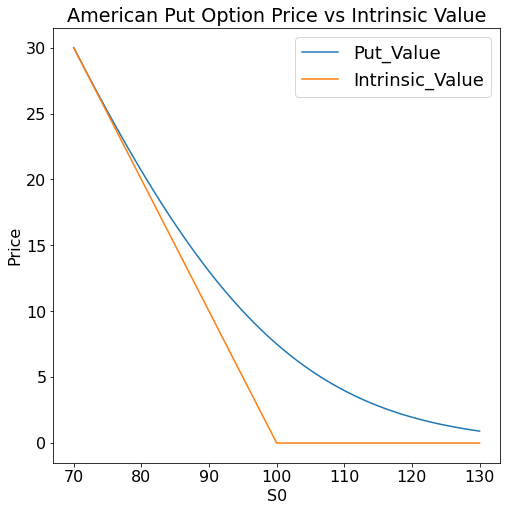

In [64]:
plt.figure()
plt.rcParams.update({'font.size':16})

american_put_df.plot(xlabel="S0",ylabel="Price",figsize=(8,8))
plt.legend(fontsize=18)
plt.title("American Put Option Price vs Intrinsic Value")

In [39]:
american_put_df.loc[70]

Put_Value          30.0
Intrinsic_Value    30.0
Name: 70, dtype: float64

It may be optimal to exercise early when the initial asset price is at or close to 0, if the underlying prices reaches 0 it will never recover, in that case the payoff essentially becomes the constant strike price $K$. Clearly it is not optimal to exercise early when the asset price is above the strike, this can also be seen in the graph by the fact that the intrinsic value sits below put value, in other the continuation value is higher. But when is closer to 70 and lower, it becomes optimal to exercise early. It should be noted that this is not a graph of the continuation value but the put value, which will be the maximum between the intrinsic value and continuation value. So when the 2 lines cross over it here it becomes optimal to exercise early. 

When the option begins deep in the money it may be optimal to exercise early, though such an options price will approach the intrinsic value anyway, in a real world scenario invloving transaction costs and bid-ask spreads it may not be optimal to immediately exercise

Varying volatility $\sigma$...

In [68]:
@interact(sigma=(0.1,0.8,0.1))
def sigmaplots(sigma=0.2):
    put_payoff=lambda x,k:np.maximum(k-x,0)
    N=500
    s0=np.arange(70,131,1)
    K=100
    lmda=1.5
    T=1
    r=0.01
    M=len(s0)

    american_put=np.zeros((M,2))

    for i,s in enumerate(s0):
        V=AmericanTrinomialTree(s,sigma,lmda,r,N,put_payoff,T,K)[0]
        american_put[i,0]=V[0,0] #time-zero value of option
        american_put[i,1]=put_payoff(s,K) #intrinsic value of option

    american_put_df=pd.DataFrame(american_put,columns=["Put_Value","Intrinsic_Value"])
    american_put_df.index=s0
    plt.figure()
    plt.rcParams.update({'font.size':20})
    american_put_df.plot(xlabel="S0",ylabel="Price",figsize=(8,8))
    plt.legend(fontsize=20)
    plt.title("American Put Option vs Intrinsic Value $\sigma=%.2f$"%sigma)
    

interactive(children=(FloatSlider(value=0.2, description='sigma', max=0.8, min=0.1), Output()), _dom_classes=(…

As the volatility increases the value of the american put increases above the intrinsic value. This is because the greater the volatility the more likely it is at any point for the asset price to drop below the strike, or reach the optimal exercise boundary. So at each discrete time point the continuation value is higher as there is greater potential for it to change and fall further below the strike the longer we wait.

When the volatility decreases we see that the price gets closer to the intrinsic value. By decreasing the volatility the asset will deviate less from its initial value throughout the options life, and so more closely resembles the intrinsic value. As $\sigma$ gets closer and closer to 0 the asset essentially becomes constant so the value of the american put option becomes the intrinsic value.


In [69]:
@interact(r=(0.01,0.1,0.01))
def sigmaplots(r=0.01):
    put_payoff=lambda x,k:np.maximum(k-x,0)
    N=500
    s0=np.arange(70,131,1)
    K=100
    lmda=1.5
    sigma=0.2
    T=1
    M=len(s0)

    american_put=np.zeros((M,2))

    for i,s in enumerate(s0):
        V=AmericanTrinomialTree(s,sigma,lmda,r,N,put_payoff,T,K)[0]
        american_put[i,0]=V[0,0] #time-zero value of option
        american_put[i,1]=put_payoff(s,K) #intrinsic value of option

    american_put_df=pd.DataFrame(american_put,columns=["Put_Value","Intrinsic_Value"])
    
    american_put_df.index=s0
    plt.figure()
    plt.rcParams.update({'font.size':20})
    american_put_df.plot(xlabel="S0",ylabel="Price",figsize=(8,8))
    plt.legend(fontsize=20)
    plt.title("American Put Option vs Intrinsic Value $r=%.2f$"%r)

interactive(children=(FloatSlider(value=0.01, description='r', max=0.1, min=0.01, step=0.01), Output()), _dom_…

By increasing the interest rate $r$ the value of the american put decreases and becomes closer to the intrinsic value, particularly when it starts in the money. This is because by increasing the interest rate, we discount the future values at a higher rate, so they have a much smaller present value. In other words with higher interest rates the sooner we can exercise the better to avoid the decaying value over time.

# Q1 (c)
## Lookback option

In [70]:

def Lookback_option(s0,sigma,r,N,T,lmda,american=False):

    delta_t=T/N

    #set up parameters
    u=np.exp(lmda*sigma*np.sqrt(delta_t))
    d=1/u
    qu=1/(2*lmda**2)+((r-sigma**2/2)*np.sqrt(delta_t))/(2*lmda*sigma)
    qm=1-1/lmda**2
    qd=1/(2*lmda**2)-((r-sigma**2/2)*np.sqrt(delta_t))/(2*lmda*sigma)


    S=np.zeros((2*N+1,N+1))
    V=np.zeros((N+1,N+1,2*N+1)) #N+1 arrays of size 2*Nx2*N

    #set up S[k,n]=s0*u^(n-k) = s0*u^n*d^k for 0<=k<=2n
    for t in range(N+1):
        S[0:2*t+1,t]=(s0*u**t)*(d**(np.arange(0,2*t+1)))

    #Set up grid for auxillary function m_j^n
    M=np.zeros((N+1,N+1))
    for t in range(0,N+1):
        M[0:t+1,t]=s0*u**np.arange(t,-1,-1)

    #apply payoff
    #note the index is reversed from the lecture notes
    for k in range(0,2*N+1):
        jmax=min(k,N)
        for j in range(0,jmax+1):
            V[N,j,k]=M[j,N]-S[k,N]


    phi=lambda k,j:min(k,j+1) #shooting function

    # now iterate back through the tree

    for n in reversed(range(0,N)):

        for k in range(2*n+1):
            jmax=min(k,n)
            for j in range(0,jmax+1):
                if(american==True):
                    V[n,j,k]=np.maximum(M[j,n]-S[k,n],np.exp(-r*delta_t)*(qu*V[n+1,phi(k,j),k]+qm*V[n+1,phi(k+1,j),k+1]+qd*V[n+1,phi(k+2,j),k+2]))
                else:
                    V[n,j,k]=np.exp(-r*delta_t)*(qu*V[n+1,phi(k,j),k]+qm*V[n+1,phi(k+1,j),k+1]+qd*V[n+1,phi(k+2,j),k+2])
    return V

In [19]:
N=2
s0=100
lmda=1.5
sigma=0.2
T=1
r=0.01

V_am,S,M=Lookback_option(s0,sigma,r,N,T,lmda,True)
V_euro=Lookback_option(s0,sigma,r,N,T,lmda,False)

In [71]:
N_vec=100*np.arange(1,6)
american_lookback=np.zeros(5)
euro_lookback=np.zeros(5)
times=np.zeros((5,2))
s0=100
lmda=1.5
sigma=0.2
T=1
r=0.01
for i,N in enumerate(N_vec):
    #time the european lookback
    t0=time.time()
    euro_lookback[i]=Lookback_option(s0,sigma,r,N,T,lmda)[0,0,0]
    dt=time.time()-t0
    times[i,0]=dt
    
    #time the american lookback
    t0=time.time()
    american_lookback[i]=Lookback_option(s0,sigma,r,N,T,lmda,True)[0,0,0]
    dt=time.time()-t0
    times[i,1]=dt
    
lookback_df=pd.DataFrame([euro_lookback,times[:,0],american_lookback,times[:,1]],
                         columns=["N=%i"%i for i in N_vec], index=["European Option","European time","American Option","American Time"]
                        )

In [72]:
lookback_df

,N=100,N=200,N=300,N=400,N=500
European Option,14.750883,15.218390,15.430247,15.557935,15.645676
European time,1.732842,12.977005,44.526385,106.493496,205.873548
American Option,14.883068,15.350834,15.562853,15.690664,15.778485
American Time,2.853724,22.942637,77.719289,183.752525,398.034645


In [22]:
#caluclate computation times empirically

N_vec=np.arange(20,320,20)
time_vec=np.zeros(len(N_vec))

for i,N in enumerate(N_vec):
    t0=time.time()
    Lookback_option(s0,sigma,r,N,T,lmda)
    dt=time.time()-t0
    time_vec[i]=dt

Text(0.5, 1.0, 'Plot of computation time against number of periods (Log-Log-Scale)')

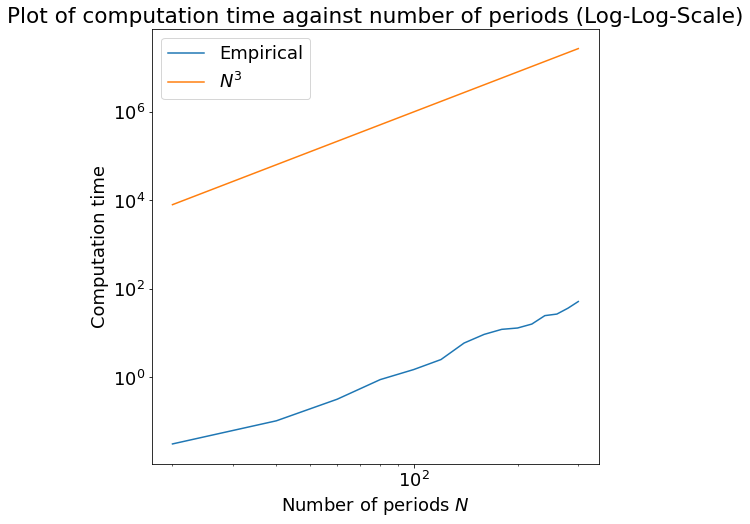

In [55]:
plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size':18})
plt.loglog(N_vec,time_vec,label="Empirical")
plt.loglog(N_vec,N_vec**3,label="$N^3$")
plt.legend(fontsize=18)
plt.xlabel("Number of periods $N$")
plt.ylabel("Computation time")
plt.title("Plot of computation time against number of periods (Log-Log-Scale)")

Since this is a path dependent option how fine our lattice or grid is has a significant impact on the accuracy of prices. This is because between any two discretised points of the asset trajectory the asset can take on values that won't be captured. Small movements like these can change the historical maximum of the stock, particularly if we are quite close to the maximum already. To this end since we are working over the time frame of 1 year, within a single day it is entirely possible for the asset to reach a new maximum at some point and fall below the previous maximum again by the end of the day. Depending on the number of points we observe the number of grid points corresponding to a single day we could easily miss these changes, leading to slight inaccuracies.

In order to obtain reliable prices it is likely necessary to use $N$ close to 1000, which would correspond to just under 4 points a day (for 252 trading days in 1 year). However at 500 points the computation is already quite slow. We can see from the plot of the computation times that it scales similarly to a rate of $O(N^3)$. In this sense the computation time scales far too quickly with the number of periods

In [24]:
def FloatLookBackPut(s0,r,sigma,T):
    #x*=x
    #x=s0
    d1=1/(sigma*np.sqrt(T))*(np.log(1)+(r+1/2*sigma**2)*T)
    d2=1/(sigma*np.sqrt(T))*(np.log(1)+(r-1/2*sigma**2)*T)
    
    return (1+sigma**2/(2*r))*s0*stats.norm.cdf(d1)+np.exp(-r*T)*s0*stats.norm.cdf(-d2)-sigma**2/(2*r)*np.exp(-r*T)*s0*stats.norm.cdf(-d2)-s0

In [25]:
FloatLookBackPut(100,0.01,0.2,1)

16.408774883070578

In [74]:
Lookback_option(100,0.2,0.01,500,1,1.5)[0][0,0]

15.645675542228636